# Project 1

For your first project you are going to go through each of the following functions and optimize in terms of memory and speed. You can import any libraries and perform any code transformations but the end result must be equal in order to be correct.

I recommend that you create a separate notebook or open an IDE and experiment there. Then come back to this notebook and write your answer. Each function has a cell with the original function, another one for your solution, and a profiling and correctness checker. The final submission will be this notebook plus a consecutive run in your PC (restart, run all and save as html) and another run on your raspberry Pi. You will submit all three files on Canvas.

The first cell is used to import the libraries we need to run these functions, the second cell will be for your libraries

## Write your information here
Name: Preston Tai

Student Id #: 83952129

UCI ID: prestoht

In [1]:
import numpy as np
import ctypes
import math
import time
from scipy import misc,ndimage
import matplotlib.pyplot as plt
from PIL import Image
from numba import jit
import requests
from io import BytesIO
!pip install opencv-python ##Enable if first time running
!pip install memory_profiler
import cv2
%load_ext memory_profiler

In [2]:
#### Import your libraries here
from numba import prange, vectorize, guvectorize, njit, typeof, float64
!pip3 install NumbaSummarizer

from NumbaSummarizer import Simd_profile

#from numba import jit, njit, typeof, int32, int64, float32, float64, prange, vectorize, guvectorize, typeof
from functools import wraps, partial
import time

def eager_decorator(old_func):
    cache = dict() # maps function to its fastest version
    @wraps(old_func)
    def new_func(*args, **kwargs):
        if old_func in cache:
            #if old_func != cache[old_func]:
            #    print('numba decorator used')
            return cache[old_func](*args, **kwargs)
        arg_typings = [typeof(arg) for arg in args]
        argc = len(arg_typings)

        #run normally and get return typings for eager compilation
        start = time.perf_counter()
        res = old_func(*args, **kwargs)
        old_duration = time.perf_counter() - start
        res_typings = typeof(res)    
        
        #running numba with eager compilation
        start = time.perf_counter()
        numba_f = njit((res_typings)(*arg_typings), parallel=True)(old_func)
        numba_duration = time.perf_counter() - start

        if old_duration < numba_duration:
            cache[old_func] = old_func
        else:
            cache[old_func] = numba_f
        return res
    return new_func



The output of both functions is not the same


In [3]:
url1="http://getwallpapers.com/wallpaper/full/c/a/7/1235918-3000-x-3000-hd-wallpapers-3000x2000-for-hd-1080p.jpg"
url2="http://getwallpapers.com/wallpaper/full/c/4/1/1235927-3000-x-3000-hd-wallpapers-3000x2000-screen.jpg"
response1 = requests.get(url1)
response2 = requests.get(url2)

### These will be used as input arrays, they are all images transformed to numpy arrays
#A = Image.open('nature.jpg')
# convert image to numpy array
A = Image.open(BytesIO(response1.content))
A = np.asarray(A)/255
A = np.mean(A, axis=2)*255

#B = Image.open('sun.jpg')
# convert image to numpy array
B = Image.open(BytesIO(response2.content))
B = np.asarray(B)/255
B = np.mean(B, axis=2)*255
C=np.random.rand(A.shape[0],A.shape[1])*255




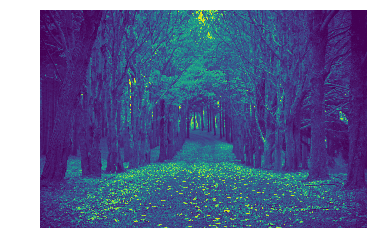

In [4]:
### Verify the images are there and they are grayscale

plt.axis('off')
plt.imshow(A)
plt.show()


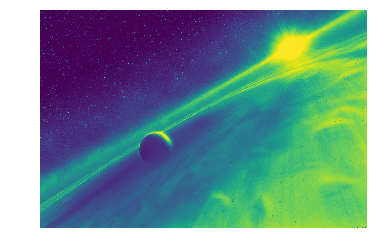

In [5]:
plt.axis('off')
plt.imshow(B)
plt.show()


## Loop 1

In [6]:
def loop1(A,B):
    a=np.copy(A)
    b=np.copy(B)

    for j in range (1,a.shape[0]-1):
        for i in range (1,a.shape[1]-1):
            a[j,i] = a[j - 1,i] + b[j,i];
            b[j,i] = b[j,i]**2
        
    return a,b
    
        
        


In [7]:
%%time
x=loop1(A,B)

CPU times: user 10.3 s, sys: 187 ms, total: 10.5 s
Wall time: 22.4 s


In [8]:
%memit x=loop1(A,B)

peak memory: 461.83 MiB, increment: 0.00 MiB


In [9]:
@eager_decorator
#@Simd_profile
#@njit('Tuple((float64[:,:], float64[:,:]))(float64[:,:], float64[:,:])')
def loop1_sol(A,B):
    a=np.copy(A)
    b=np.copy(B)

    for i in prange (1,a.shape[1]-1):
        for j in range (1,a.shape[0]-1):
            a[j,i] = a[j - 1,i] + b[j,i];
            b[j,i] = b[j,i] **2;
                
    ### Your code
        
    return a,b

In [10]:
temp = loop1_sol(A,B)
del temp

In [11]:
%%time
x,y=loop1_sol(A,B)

CPU times: user 142 ms, sys: 13 ms, total: 155 ms
Wall time: 140 ms


In [12]:
%memit x,y=loop1_sol(A,B)

peak memory: 473.81 MiB, increment: 0.00 MiB


In [13]:
##### If output is false, then your solution is incorrect
x,y=loop1(A,B)
x1,y1=loop1_sol(A,B)
print(np.allclose(x, x1))
print(np.allclose(y, y1))

# All this rounding error is because of how python and numba behave differently
# python has limitations.  its representation of floating point numbers is imprecise
# https://docs.python.org/3/tutorial/floatingpoint.html#tut-fp-issues
# https://stackoverflow.com/questions/53042250/mean-from-pandas-and-numpy-differ/53190636#53190636
# numpy's rounding is actually better because it uses something similar to pairwise summation

True
True


In [14]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,y,x1,y1

## Loop 2

In [15]:
def loop2(A, B, C):
    a=np.copy(A)
    b=np.copy(B)

    for j in range (1,a.shape[0]-1):
        for i in range (1,a.shape[1]-1):
            a[j][i] = a[j-1][i] + C[j][i]
        for i in range (1,b.shape[1]-1):
            b[j][i] = b[j][i-1] + C[j][i]

        
    return a, b

In [16]:
%%time
X=loop2(A,B,C)

CPU times: user 12.9 s, sys: 99.7 ms, total: 13 s
Wall time: 14.1 s


In [17]:
%memit X=loop2(A,B,C)

peak memory: 582.19 MiB, increment: 0.00 MiB


In [18]:
@njit('Tuple((float64[:,:], float64[:,:]))(float64[:,:], float64[:,:], float64[:,:])')
def loop2_sol(A, B, C):
    a=np.copy(A)
    b=np.copy(B)

    for j in prange (1,a.shape[0]-1):
        for i in prange (1,a.shape[1]-1):
            a[j][i] = a[j-1][i] + C[j][i]
          
    for j in prange (1,a.shape[0]-1):
        for i in prange (1,b.shape[1]-1):
            b[j][i] = b[j][i-1] + C[j][i]

    #### Your code
        
    return a, b

In [19]:
temp = loop2_sol(A,B,C)
del temp

In [20]:
%%time
X=loop2_sol(A,B,C)

CPU times: user 49.6 ms, sys: 8.83 ms, total: 58.4 ms
Wall time: 60 ms


In [21]:
%memit X=loop2_sol(A,B,C)

peak memory: 493.74 MiB, increment: -0.09 MiB


In [22]:
##### If output is false, then your solution is incorrect
x,y=loop2(A,B,C)
x1,y1=loop2_sol(A,B,C)
print(np.array_equal(x,x1))
print(np.array_equal(y,y1))

True
True


In [23]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,y,x1,y1

## Matrix multiplication

In [24]:
# SGEMM Form => C := alpha*A*B + beta*C,
# We create new variable because the images are too big
Am=np.random.rand(100,500)
Bm=np.random.rand(500,250)
Dm=np.random.rand(100,250)
# alpha and beta are constant floating point values, reuse them for your solution
alpha = 1.5
beta = 1.2 

def sgemm_manual (alpha,A, B, beta, D):

    d=np.copy(D)
    for i in range(d.shape[0]):
        for j in range(d.shape[1]):
            d[i,j] *= beta
        for k in range(A.shape[1]):
            for j in range(d.shape[1]):
                d[i,j] += alpha * A[i,k] * B[k,j]
    return d            


In [25]:
%%time
x=sgemm_manual (alpha,Am, Bm, beta, Dm) ## We transpose B because we need the following to be true
# A is NIxNK
# B is NKxNJ
# C is NIxNJ

CPU times: user 11.9 s, sys: 83 ms, total: 12 s
Wall time: 12.5 s


In [26]:
%memit x=sgemm_manual (alpha,Am, Bm, beta, Dm)

peak memory: 587.14 MiB, increment: 0.13 MiB


In [27]:
#@eager_decorator
@njit
def sgemm_solution (alpha,A, B, beta, D):
    d=np.copy(D)
    return np.dot(np.multiply(alpha, A), B) + np.multiply(beta, D)

    ###your code

    '''
    d = np.multiply(d, beta)
    for i in prange(d.shape[0]):
        for k in prange(A.shape[1]):
            for j in prange(d.shape[1]):
                d[i,j] += alpha * A[i,k] * B[k,j]
    '''


In [28]:
temp = sgemm_solution(alpha,Am, Bm, beta, Dm)
del temp

In [29]:
%%time
x=sgemm_solution (alpha,Am, Bm, beta, Dm)

CPU times: user 2.14 ms, sys: 47 µs, total: 2.19 ms
Wall time: 1.82 ms


In [30]:
%memit x=sgemm_solution (alpha,Am, Bm, beta, Dm)

peak memory: 534.18 MiB, increment: -0.28 MiB


In [31]:
##### If output is false, then your solution is incorrect
x=sgemm_manual (alpha,Am, Bm, beta, Dm)
x1=sgemm_solution (alpha,Am, Bm, beta, Dm)
print(np.allclose(x,x1))

True


In [32]:
##### Cleanup, get rid of all the objects we don't need anymore
del x,x1, Am, Bm, Dm

## Laplacian operator

In [33]:
def Laplacian_Operator(A):
    x = A.shape[0]
    y = A.shape[1]
    laplacian = np.empty((x - 2, y - 2))
    for i in range(1, x - 1):
        for j in range(1, y - 1):
            laplacian[i-1, j-1] = np.abs(A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1] - 4*A[i, j]) > 0.05
    return laplacian


In [34]:
%%time
LO=Laplacian_Operator(A)


CPU times: user 22.8 s, sys: 215 ms, total: 23 s
Wall time: 24.6 s


In [35]:
%memit LO=Laplacian_Operator(A)

peak memory: 488.51 MiB, increment: 45.57 MiB


In [42]:
@eager_decorator
def Laplacian_Operator_Sol(A):
    x = A.shape[0]
    y = A.shape[1]
    laplacian = np.empty((x - 2, y - 2))
    for i in prange(1, x - 1):
        for j in prange(1, y - 1):
            laplacian[i-1, j-1] = np.abs(A[i-1, j] + A[i+1, j] + A[i, j-1] + A[i, j+1] - 4*A[i, j]) > 0.05
            
    # i tried iterating through the loop backwards, but it ended up not helping
    # numba have parallel=True if step size is negative
    return laplacian


In [43]:
temp = Laplacian_Operator_Sol(A)
del temp

In [44]:
%%time
LO=Laplacian_Operator_Sol(A)

CPU times: user 19.8 ms, sys: 1.96 ms, total: 21.8 ms
Wall time: 15.3 ms


In [45]:
##### If output is false, then your solution is incorrect
LO=Laplacian_Operator(A)
SOL=Laplacian_Operator_Sol(A)
print(np.allclose(LO,SOL))

True


In [46]:
%memit LO=Laplacian_Operator_Sol(A)

peak memory: 597.30 MiB, increment: 0.03 MiB


In [47]:
##### Cleanup, get rid of all the objects we don't need anymore
del LO, SOL